# LeNet-5 Architechture

Taken from DATA586 Lab 3 MDS UBCO

In [151]:
import os
import time
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import LongTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps  
import cv2


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [185]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 15

# Architecture
NUM_FEATURES = 120*100
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = True

## Loading Data

In [186]:
#loading faces
#double check that we can read them in fine

import pandas as pd
train1 = pd.read_pickle('../data/final/UScongress_train_1.pkl')
train2 = pd.read_pickle('../data/final/UScongress_train_2.pkl')
train = pd.concat([train1, train2])
valid = pd.read_pickle('../data/final/UScongress_validation.pkl')
test = pd.read_pickle('../data/final/UScongress_test.pkl')
del(train1, train2)

#change R and D to 0 and 1
train['party'] = train['party'].replace(['R', 'D'], [0, 1])
valid['party'] = valid['party'].replace(['R', 'D'], [0, 1])
test['party'] = test['party'].replace(['R', 'D'], [0, 1])

#reset indices
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [187]:
#https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
class congressDataset(Dataset):
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X, self.y[index]
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((120, 100)),
        transforms.Grayscale(1),
        transforms.ToTensor()])
    

#using dataset class
train_dataset = congressDataset(train['picArray'], LongTensor(train['party']))
test_dataset = congressDataset(test['picArray'], LongTensor(test['party']))

#loading data using torch's DataLoader function
train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)


# Checking the dataset
for images, labels in train_dl:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# # Checking the dataset
for images, labels in test_dl:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([128, 1, 120, 100])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 1, 120, 100])
Image label dimensions: torch.Size([128])


In [188]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_dl):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


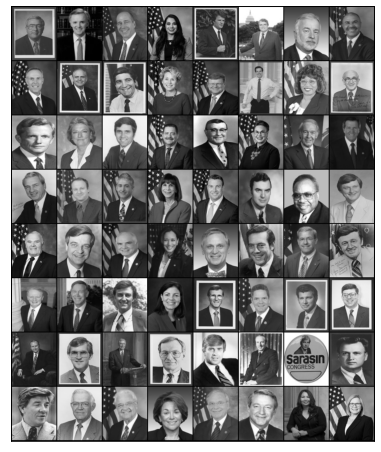

In [189]:
#just for interests sake

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

## Data Augmentation

In [190]:
#define transform
train_transform = transforms.Compose([transforms.Resize((120, 100)),
                                      transforms.AutoAugment(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(0.5, 0.5)], 
                                      )

## Model

In [198]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=True):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=10),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=10),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(864*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Dropout(0.6),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Dropout(0.8),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [199]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  

### Without Augmentation

In [200]:
#training
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

    
#main loop
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_dl):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_dl), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_dl, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/015 | Batch 0000/0012 | Cost: 0.6847
Epoch: 001/015 | Train: 53.179%
Time elapsed: 0.06 min
Epoch: 002/015 | Batch 0000/0012 | Cost: 0.6874
Epoch: 002/015 | Train: 52.517%
Time elapsed: 0.12 min
Epoch: 003/015 | Batch 0000/0012 | Cost: 0.6855
Epoch: 003/015 | Train: 52.781%
Time elapsed: 0.17 min
Epoch: 004/015 | Batch 0000/0012 | Cost: 0.6744
Epoch: 004/015 | Train: 54.967%
Time elapsed: 0.23 min
Epoch: 005/015 | Batch 0000/0012 | Cost: 0.6956
Epoch: 005/015 | Train: 56.887%
Time elapsed: 0.28 min
Epoch: 006/015 | Batch 0000/0012 | Cost: 0.6871
Epoch: 006/015 | Train: 59.205%
Time elapsed: 0.34 min
Epoch: 007/015 | Batch 0000/0012 | Cost: 0.6768
Epoch: 007/015 | Train: 58.742%
Time elapsed: 0.41 min
Epoch: 008/015 | Batch 0000/0012 | Cost: 0.6846
Epoch: 008/015 | Train: 59.139%
Time elapsed: 0.47 min
Epoch: 009/015 | Batch 0000/0012 | Cost: 0.6510
Epoch: 009/015 | Train: 58.543%
Time elapsed: 0.54 min
Epoch: 010/015 | Batch 0000/0012 | Cost: 0.6734
Epoch: 010/015 | Train: 5

In [201]:
#evaluation
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_dl, device=DEVICE)))

Test accuracy: 53.87%


### With Augmentation